In [2]:
#!pip install pandas matplotlib

In [1]:
#!python3 -m pip install 'tensorflow[and-cuda]'

The goal of this project is to create deep learning models that predict the next words in a sentence.

Two approaches will be used: LSTM (Long Short Term Memory) RNN (Recurrent Neural Network) and a sequence model with Transformers architecture.

The models will be tailored for the use in completing Haiku poems.

The base textual dataset is the "Haiku Dataset" that can be found at Kaggle:

In [2]:
!nvidia-smi

Mon Mar 10 23:31:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8             15W /  125W |      18MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from collections import Counter
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import numpy as np
import pandas as pd
import random
import re
import string
import matplotlib.pyplot as plt

#### Step 0 - Dataset parsing, cleaning and exploration

Dataset can be downloaded from: <br>
https://www.kaggle.com/datasets/hjhalani30/haiku-dataset

In [5]:
# Dataset is already downloaded from kaggle and available in current directory
df = pd.read_csv('all_haiku.csv')
# df = pd.read_csv('bbc_news.csv')
# df = df.sample(frac=0.3)

In [6]:
df.groupby(['source']).count()

,Unnamed: 0,0,1,2,hash
source,,,,,
gutenberg,5494,5494,5494,5494,5494
img2poems,13538,13538,13538,13538,13538
sballas,8131,8131,8131,8130,8130
tempslibres,5233,5233,5233,5233,5233
twaiku,111727,111727,111727,111727,111727


In [7]:
# Filter only the haikus from sballas source since they appear more concise
source_filter = df['source'].isin(['sballas', 'tempslibres'])
df[source_filter].sample(5)

,Unnamed: 0,0,1,2,source,hash
2658,2674,August Friday happy hour---,the bartenders have time,to listen,tempslibres,AUGUSTFRIDAYHAPPYHOURTHEBARTENDERSHAVETIMETOLI...
1397,1405,a tiny world,unfolds and thrives -,summer rain,tempslibres,ATINYWORLDUNFOLDSANDTHRIVESSUMMERRAIN
25320,6721,a breeze,through paper lanterns,the dancer lifts her fan,sballas,ABREEZETHROUGHPAPERLANTERNSTHEDANCERLIFTSHERFAN
21142,2404,ocean breeze,a pitcher and his interpreter,walk to the bullpen,sballas,OCEANBREEZEAPITCHERANDHISINTERPRETERWALKTOTHEB...
24033,5323,warm afternoon,my daughter's eyes close,as i read,sballas,WARMAFTERNOONMYDAUGHTERSEYESCLOSEASIREAD


In [8]:
df = df[source_filter]

In [9]:
df = df[['0', '1', '2']]
df

,0,1,2
0,fishing boats,colors of,the rainbow
1,ash wednesday--,trying to remember,my dream
2,snowy morn--,pouring another cup,of black coffee
3,shortest day,flames dance,in the oven
4,haze,half the horse hidden,behind the house
...,...,...,...
26897,coconut grove,leaf blades comb,the moonlight
26898,alpine lake?,my?breast'stroke's'shining?arc,toward sunrise
26899,spruce woods,fireweed filling,the vacancy
26900,corrugated sun?,chilies and laundry,in rooftop haze


In [10]:
# Combining the lines and doing basic pre-processing
df['complete'] = df['0'] + ' ' + df['1'] + ' ' + df['2']
#df.rename(columns={'description': 'complete'}, inplace=True)
df['complete'] = df['complete'].apply(lambda x: str(x))
df['complete'] = df['complete'].apply(lambda x: x.lower())
df.dropna(inplace=True)
df.drop_duplicates(inplace=True, subset='complete')
df

,0,1,2,complete
0,fishing boats,colors of,the rainbow,fishing boats colors of the rainbow
1,ash wednesday--,trying to remember,my dream,ash wednesday-- trying to remember my dream
2,snowy morn--,pouring another cup,of black coffee,snowy morn-- pouring another cup of black coffee
3,shortest day,flames dance,in the oven,shortest day flames dance in the oven
4,haze,half the horse hidden,behind the house,haze half the horse hidden behind the house
...,...,...,...,...
26897,coconut grove,leaf blades comb,the moonlight,coconut grove leaf blades comb the moonlight
26898,alpine lake?,my?breast'stroke's'shining?arc,toward sunrise,alpine lake? my?breast'stroke's'shining?arc to...
26899,spruce woods,fireweed filling,the vacancy,spruce woods fireweed filling the vacancy
26900,corrugated sun?,chilies and laundry,in rooftop haze,corrugated sun? chilies and laundry in rooftop...


In [11]:
# Cleaning function
def clean_text(sentence):
    # Remove punctuation (only keep white space, letters and apostrophe)
    sentence = re.sub(r"[^\w\s']", '', sentence)
    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)  # Remove number digits
    return sentence

In [12]:
df

,0,1,2,complete
0,fishing boats,colors of,the rainbow,fishing boats colors of the rainbow
1,ash wednesday--,trying to remember,my dream,ash wednesday-- trying to remember my dream
2,snowy morn--,pouring another cup,of black coffee,snowy morn-- pouring another cup of black coffee
3,shortest day,flames dance,in the oven,shortest day flames dance in the oven
4,haze,half the horse hidden,behind the house,haze half the horse hidden behind the house
...,...,...,...,...
26897,coconut grove,leaf blades comb,the moonlight,coconut grove leaf blades comb the moonlight
26898,alpine lake?,my?breast'stroke's'shining?arc,toward sunrise,alpine lake? my?breast'stroke's'shining?arc to...
26899,spruce woods,fireweed filling,the vacancy,spruce woods fireweed filling the vacancy
26900,corrugated sun?,chilies and laundry,in rooftop haze,corrugated sun? chilies and laundry in rooftop...


In [13]:
df['complete'] = df['complete'].apply(clean_text)
# Notice that punctuation dissapears
df 

,0,1,2,complete
0,fishing boats,colors of,the rainbow,fishing boats colors of the rainbow
1,ash wednesday--,trying to remember,my dream,ash wednesday trying to remember my dream
2,snowy morn--,pouring another cup,of black coffee,snowy morn pouring another cup of black coffee
3,shortest day,flames dance,in the oven,shortest day flames dance in the oven
4,haze,half the horse hidden,behind the house,haze half the horse hidden behind the house
...,...,...,...,...
26897,coconut grove,leaf blades comb,the moonlight,coconut grove leaf blades comb the moonlight
26898,alpine lake?,my?breast'stroke's'shining?arc,toward sunrise,alpine lake mybreast'stroke's'shiningarc towar...
26899,spruce woods,fireweed filling,the vacancy,spruce woods fireweed filling the vacancy
26900,corrugated sun?,chilies and laundry,in rooftop haze,corrugated sun chilies and laundry in rooftop ...


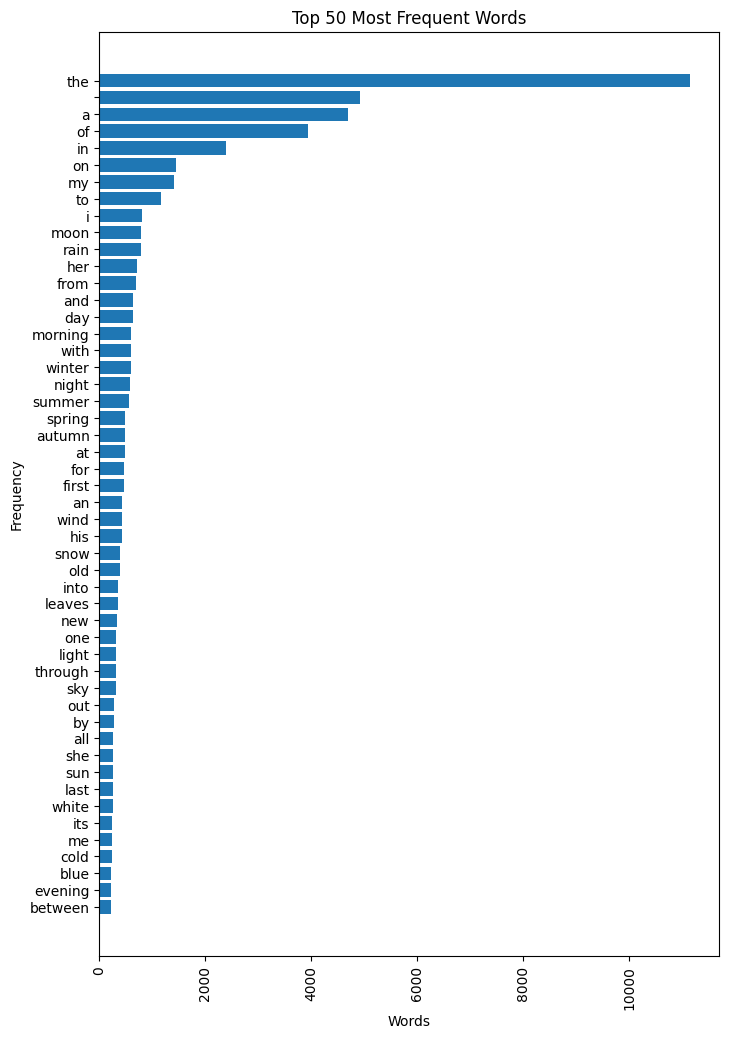

In [14]:
all_words = []
for i, sentence in df.iterrows():
    words = sentence['complete'].split(' ')
    all_words.extend(words)

# Count word frequencies
word_counts = Counter(all_words)

# Get top 100 words
top_words = word_counts.most_common(300)

# Convert to lists for plotting
words, counts = zip(*top_words)

words = words[::-1]
counts = counts[::-1]

# Plot
plt.figure(figsize=(8, 12))
plt.barh(words[250:300], counts[250:300])
plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 50 Most Frequent Words")
plt.show()

#### Step 1: Creating train values and labels with ngrams

In [15]:
# declare ngrams
input_sequences = []
for line in list(df['complete']):
    tokens = line.strip().split(' ')
    for i in range(1, len(tokens)):
        n_gram_sequence = tokens[:i+1]
        input_sequences.append(n_gram_sequence)

In [16]:
print('Train len:', len(input_sequences))
#print('Val len:', len(input_val_sequences))

Train len: 109180


In [17]:
input_sequences[0:3]

[['fishing', 'boats'],
 ['fishing', 'boats', 'colors'],
 ['fishing', 'boats', 'colors', 'of']]

In [18]:
X = [' '.join(words[0:-1]) for words in input_sequences]
y = [words[-1] for words in input_sequences]

In [19]:
X

['fishing',
 'fishing boats',
 'fishing boats colors',
 'fishing boats colors of',
 'fishing boats colors of the',
 'ash',
 'ash wednesday',
 'ash wednesday trying',
 'ash wednesday trying to',
 'ash wednesday trying to remember',
 'ash wednesday trying to remember ',
 'ash wednesday trying to remember  my',
 'snowy',
 'snowy morn',
 'snowy morn pouring',
 'snowy morn pouring another',
 'snowy morn pouring another cup',
 'snowy morn pouring another cup of',
 'snowy morn pouring another cup of black',
 'shortest',
 'shortest day',
 'shortest day flames',
 'shortest day flames dance',
 'shortest day flames dance in',
 'shortest day flames dance in the',
 'haze',
 'haze half',
 'haze half the',
 'haze half the horse',
 'haze half the horse hidden',
 'haze half the horse hidden behind',
 'haze half the horse hidden behind the',
 'low',
 'low sun',
 'low sun the',
 'low sun the lady',
 'low sun the lady in',
 'low sun the lady in red',
 'low sun the lady in red on',
 'low sun the lady in re

In [20]:
y

['boats',
 'colors',
 'of',
 'the',
 'rainbow',
 'wednesday',
 'trying',
 'to',
 'remember',
 '',
 'my',
 'dream',
 'morn',
 'pouring',
 'another',
 'cup',
 'of',
 'black',
 'coffee',
 'day',
 'flames',
 'dance',
 'in',
 'the',
 'oven',
 'half',
 'the',
 'horse',
 'hidden',
 'behind',
 'the',
 'house',
 'sun',
 'the',
 'lady',
 'in',
 'red',
 'on',
 'high',
 'heels',
 'the',
 'passing',
 'stranger',
 'farts',
 'a',
 'bubble',
 'in',
 'the',
 'ice',
 'new',
 'asphalt',
 'in',
 'the',
 'holes',
 "night'",
 '',
 '',
 '',
 'gusts',
 'of',
 'rain',
 '',
 '',
 '',
 '',
 '',
 '',
 'outside',
 'the',
 'sound',
 'of',
 'a',
 'horse',
 'galloping',
 'through',
 'leaves',
 'stars',
 'suddenly',
 'a',
 'whiff',
 'of',
 'perfume',
 'half',
 'of',
 'the',
 'moon',
 'hidden',
 'another',
 'leaf',
 'down',
 'the',
 'sound',
 'of',
 'one',
 'hand',
 'clapping',
 'sound',
 'of',
 'geese',
 'drowned',
 'by',
 'the',
 'sound',
 'of',
 'the',
 'train',
 'this',
 'morning',
 'sun',
 'my',
 'shadow',
 'over'

In [21]:
len(y)

109180

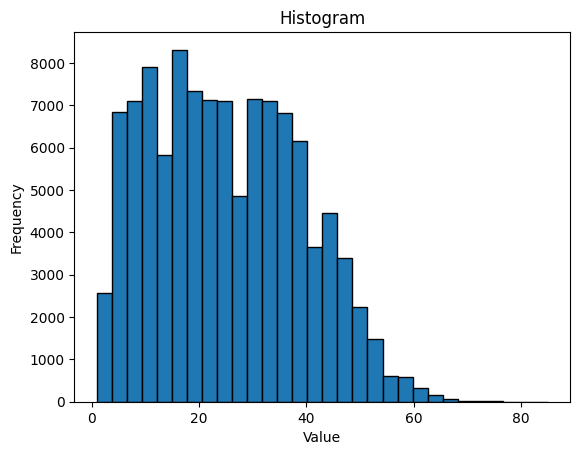

Max sequence size: 85


In [22]:
# Visualize typical sequence size
def plot_histogram(data, bins=10):
    plt.hist(data, bins=bins, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()

input_sequence_sizes = [len(seq) for seq in X]
plot_histogram(input_sequence_sizes, bins=30)
print('Max sequence size:', max(input_sequence_sizes))

In [23]:
# Aditional cleaning of white spaces
curated_X = []
curated_y = []

for i, output in enumerate(y):
    if output not in ['', ' ', '  ', '    '] and len(X[i])<=100 :
        curated_X.append(X[i])
        curated_y.append(y[i])

In [24]:
curated_X

['fishing',
 'fishing boats',
 'fishing boats colors',
 'fishing boats colors of',
 'fishing boats colors of the',
 'ash',
 'ash wednesday',
 'ash wednesday trying',
 'ash wednesday trying to',
 'ash wednesday trying to remember ',
 'ash wednesday trying to remember  my',
 'snowy',
 'snowy morn',
 'snowy morn pouring',
 'snowy morn pouring another',
 'snowy morn pouring another cup',
 'snowy morn pouring another cup of',
 'snowy morn pouring another cup of black',
 'shortest',
 'shortest day',
 'shortest day flames',
 'shortest day flames dance',
 'shortest day flames dance in',
 'shortest day flames dance in the',
 'haze',
 'haze half',
 'haze half the',
 'haze half the horse',
 'haze half the horse hidden',
 'haze half the horse hidden behind',
 'haze half the horse hidden behind the',
 'low',
 'low sun',
 'low sun the',
 'low sun the lady',
 'low sun the lady in',
 'low sun the lady in red',
 'low sun the lady in red on',
 'low sun the lady in red on high',
 'advent',
 'advent the',

In [25]:
curated_y

['boats',
 'colors',
 'of',
 'the',
 'rainbow',
 'wednesday',
 'trying',
 'to',
 'remember',
 'my',
 'dream',
 'morn',
 'pouring',
 'another',
 'cup',
 'of',
 'black',
 'coffee',
 'day',
 'flames',
 'dance',
 'in',
 'the',
 'oven',
 'half',
 'the',
 'horse',
 'hidden',
 'behind',
 'the',
 'house',
 'sun',
 'the',
 'lady',
 'in',
 'red',
 'on',
 'high',
 'heels',
 'the',
 'passing',
 'stranger',
 'farts',
 'a',
 'bubble',
 'in',
 'the',
 'ice',
 'new',
 'asphalt',
 'in',
 'the',
 'holes',
 "night'",
 'gusts',
 'of',
 'rain',
 'outside',
 'the',
 'sound',
 'of',
 'a',
 'horse',
 'galloping',
 'through',
 'leaves',
 'stars',
 'suddenly',
 'a',
 'whiff',
 'of',
 'perfume',
 'half',
 'of',
 'the',
 'moon',
 'hidden',
 'another',
 'leaf',
 'down',
 'the',
 'sound',
 'of',
 'one',
 'hand',
 'clapping',
 'sound',
 'of',
 'geese',
 'drowned',
 'by',
 'the',
 'sound',
 'of',
 'the',
 'train',
 'this',
 'morning',
 'sun',
 'my',
 'shadow',
 'over',
 'tombstones',
 'fishing',
 'the',
 'sound',
 'o

In [26]:
len(curated_y)

104755

In [27]:
del(X) # Delete X to preserve memory
del(y) # Delete Y to preserve memory

#### Step 2.1 - Encoding the Y labels

In [28]:
# Encoding y
label_dict = {cat: i for i, cat in enumerate(set(curated_y))}
label_dict

{'washer': 0,
 'cleaningtheoillamp': 1,
 "lou's": 2,
 "evergreen's": 3,
 'pianoblack': 4,
 'teat': 5,
 'shopkeeper': 6,
 'mantle': 7,
 'contraindications': 8,
 'nucleus': 9,
 'swallowing': 10,
 'gurgles': 11,
 'absorbed': 12,
 'school': 13,
 'lids': 14,
 'windowa': 15,
 'inky': 16,
 'clack': 17,
 'shipping': 18,
 'echoes': 19,
 'placebo': 20,
 "i'd": 21,
 'amaryllis': 22,
 'blinding': 23,
 'brochure': 24,
 "wick's": 25,
 'holy': 26,
 'chimpunk': 27,
 'particular': 28,
 'seabreeze': 29,
 'meets': 30,
 'display': 31,
 'lava': 32,
 'ring': 33,
 'point': 34,
 'clotheslines': 35,
 'auburn': 36,
 'pudding': 37,
 'triplet': 38,
 'grasses': 39,
 'ceramic': 40,
 'fears': 41,
 'exhaled': 42,
 'head': 43,
 'newmoon': 44,
 'sit': 45,
 'goodwill': 46,
 'rakes': 47,
 'furthest': 48,
 'thedistancebetweenme': 49,
 'conditions': 50,
 'pineapple': 51,
 'thenarrowtrailto': 52,
 'rinsed': 53,
 "worm's": 54,
 'amber': 55,
 'ripping': 56,
 'rhino': 57,
 'firemen': 58,
 "elk's": 59,
 'resplendent': 60,
 "pow

In [29]:
inverse_label_dict = dict(enumerate(set(curated_y)))
#inverse_label_dict = dict(enumerate(set(curated_y + curated_val_y)))
inverse_label_dict

{0: 'washer',
 1: 'cleaningtheoillamp',
 2: "lou's",
 3: "evergreen's",
 4: 'pianoblack',
 5: 'teat',
 6: 'shopkeeper',
 7: 'mantle',
 8: 'contraindications',
 9: 'nucleus',
 10: 'swallowing',
 11: 'gurgles',
 12: 'absorbed',
 13: 'school',
 14: 'lids',
 15: 'windowa',
 16: 'inky',
 17: 'clack',
 18: 'shipping',
 19: 'echoes',
 20: 'placebo',
 21: "i'd",
 22: 'amaryllis',
 23: 'blinding',
 24: 'brochure',
 25: "wick's",
 26: 'holy',
 27: 'chimpunk',
 28: 'particular',
 29: 'seabreeze',
 30: 'meets',
 31: 'display',
 32: 'lava',
 33: 'ring',
 34: 'point',
 35: 'clotheslines',
 36: 'auburn',
 37: 'pudding',
 38: 'triplet',
 39: 'grasses',
 40: 'ceramic',
 41: 'fears',
 42: 'exhaled',
 43: 'head',
 44: 'newmoon',
 45: 'sit',
 46: 'goodwill',
 47: 'rakes',
 48: 'furthest',
 49: 'thedistancebetweenme',
 50: 'conditions',
 51: 'pineapple',
 52: 'thenarrowtrailto',
 53: 'rinsed',
 54: "worm's",
 55: 'amber',
 56: 'ripping',
 57: 'rhino',
 58: 'firemen',
 59: "elk's",
 60: 'resplendent',
 61: 

In [30]:
# Save the label/index dictionary to use later in inference phase
with open("label_dict.json", "w") as json_file:
    json.dump(inverse_label_dict, json_file, indent=4)

In [31]:
# Distinct words to be predicted
len(inverse_label_dict)

11595

In [32]:
# One hot encode Y values
def to_one_hot(labels, label_dict, dimension=46):
    results = np.zeros((len(labels), dimension), dtype='int8')
    for i, label in enumerate(labels):
        results[i, label_dict[label]] = 1.
    return results

In [33]:
num_classes = len(set(curated_y))
print('Number of classes:', num_classes)

Number of classes: 11595


In [34]:
y_train = to_one_hot(curated_y, label_dict, num_classes)

In [35]:
max_length = max([len(phrase) for phrase in curated_X])

In [36]:
len(y_train[0])

11595

In [37]:
max_length

85

In [38]:
print('X len:', len(curated_X))
print('Y len', len(curated_y))

X len: 104755
Y len 104755


#### Step 2.2 - Preprocess and encode X values with TextVectorization layer

In [40]:
text_vectorization = layers.TextVectorization(
    #max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(curated_X)

batch_size = 256
train_ds = tf.data.Dataset.from_tensor_slices((curated_X, y_train))
# Be careful with the shuffle size (in this case, will use all samples, because dataset is small)
train_ds = train_ds.shuffle(len(curated_X)).batch(batch_size) 


int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [41]:
# Nice step for validation of datasets types and shapes
for inputs, targets in int_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[4])
    print("targets[0]:", targets[4])
    break

inputs.shape: (256, 85)
inputs.dtype: <dtype: 'int64'>
targets.shape: (256, 11595)
targets.dtype: <dtype: 'int8'>
inputs[0]: tf.Tensor(
[ 10  35 737   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(85,), dtype=int64)
targets[0]: tf.Tensor([0 0 0 ... 0 0 0], shape=(11595,), dtype=int8)


In [92]:
print(max_length)
print(text_vectorization.vocabulary_size())

85
11197


#### Step 3.1 - Train LSTM (Long Short Term Memory) model (a form o RNN (Recurrent Neural Network)

In [57]:
inputs = keras.Input(shape=(None,), dtype="int64")
#embedded = layers.Embedding(input_dim=len(inverse_label_dict), output_dim=256, mask_zero=False)(inputs)
embedded = layers.Embedding(input_dim=text_vectorization.vocabulary_size(), output_dim=max_length, mask_zero=False)(inputs)
#x = layers.Bidirectional(layers.LSTM(200, return_sequences=True))(embedded) #150
x = layers.Bidirectional(layers.LSTM(200))(embedded) #150
#x = layers.Bidirectional(layers.LSTM(100))(x)
#x = layers.LSTM(200, return_sequences=True)(embedded)
#x= layers.LSTM(50)(embedded)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(inverse_label_dict), activation="softmax")(x)
model = keras.Model(inputs, outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
model.summary()

early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(int_train_ds,
                    epochs=200, 
                    #validation_data=int_val_ds,
                    callbacks=early_stopping_monitor
                   )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 85)       │       951,745 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400)            │       457,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11595)          │     4,649,595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,058,940 (23.11 MB)

 Trainable params: 6,058,940 (23.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.1000 - loss: 7.4566
Epoch 2/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.1082 - loss: 6.7909
Epoch 3/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.1326 - loss: 6.4073
Epoch 4/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.1436 - loss: 6.0856
Epoch 5/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.1538 - loss: 5.8233
Epoch 6/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.1582 - loss: 5.6393
Epoch 7/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.1640 - loss: 5.4366
Epoch 8/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.1707 - loss: 5.2455
Epoch 9/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.1797 - loss: 5.0591
Epoch 10/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.1842 - loss: 4.8932
Epoch 11/200
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.1942 - loss: 4.7330
Epoch 12/200
410/41

In [58]:
# Helper function for 
def plot_histogram(data, bins=10):
    plt.hist(data, bins=bins, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()

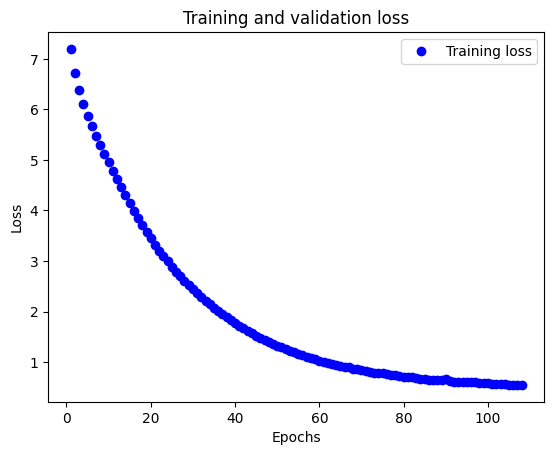

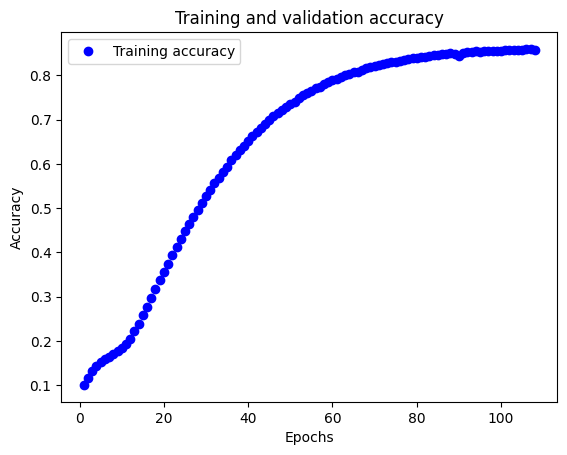

In [59]:
loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history.history["accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [60]:
# Attaching the text vectorization layer to the model to create a model ready for inference
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

# Save model
keras.models.save_model(inference_model, filepath='lstm_prediction.keras')

In [61]:
inference_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 85)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 11595)          │     6,058,940 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,058,940 (23.11 MB)

 Trainable params: 6,058,940 (23.11 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 3.2 - Testing the LSTM model

In [71]:
# Loading label dict
with open("label_dict.json", "r") as json_file:
    inverse_label_dict = json.load(json_file)

seed_texts = [
    #'lost in the woods I heard the sounds of',
    #'bedtime loud noises were coming from the',
    #'sunset on the west',
    #'rain pours in the ceiling and there is sound of',
    'leaves fall gently onto the',
    'midnight whispers carry through the',
    'echoes of laughter fade into the',
    'shadows dance upon the',
    #'the air is thick with the scent of a',
    #'time slows when the waves',
    'clouds drift lazily across another',
    'A single candle flickers in',
    'Soft footsteps vanish into',
    'Memories linger where the wind',
    'Morning dew clings to the',
    'The stars fade as dawn',
    'Hearts beat in unison under',
    'Autumn moonlight— a worm digs silently',
    'Winter seclusion— listening, that evening,',
    'A world of dew, and within every dewdrop,',
    'In the cicada’s cry, no sign can foretell',
    'Over the still pond, the dragonfly hovers',
    'Cherry blossoms drift, carried by the gentle',
    'Snow falls in silence, covering the broken',
    'Spring air fills my lungs, a sparrow sings softly',
    'The river darkens, as twilight embraces it',
    'Falling leaves scatter, whispering their last goodbye',
    'On a withered branch, a crow has settled',
    'The summer grasses— all that remains of warriors’ dreams',
    'First winter rain— even the monkey wants',
    'Clouds of butterflies— the temple bell fades into',
    'Stillness and dusk— cicada voices soak into',
    'The sea darkens— a wild duck’s call is',
    'Chrysanthemums bloom— in the old wooden temple',
    'this hambuguer tastes like'
]

model = keras.models.load_model("lstm_prediction.keras")

def top_n_indices(arr, n):
    if len(arr) < n:
        raise ValueError(f"Array must have at least {n} elements")

    return sorted(range(len(arr)), key=lambda i: arr[i], reverse=True)[:n]
    

# n=5
# next_words = 1
# answers = 1
# for seed_text in seed_texts: 
#     seed_text_original = seed_text
#     print("Prompt", seed_text)
#     for i in range(0,answers):
#         seed_text = seed_text_original
#         #for _ in range(next_words):
#         for _ in range(n):
#             seed_tensor = tf.convert_to_tensor([[seed_text]])
#             predictions_list = model.predict(seed_tensor, verbose=0)[0].tolist()
#             top_n = top_n_indices(predictions_list,n)
#             output_word = ""
#             #predicted = random.choice(top_n)
#             for index, word in inverse_label_dict.items():
#                 if int(index) == predicted:
#                     output_word = word
#                     break
#             seed_text += " " + output_word
        
#         print("Full  ", seed_text, '\n')



n = 10
for seed_text in seed_texts:
    print(seed_text)
    seed_len = len(seed_text)
    seed_tensor = tf.convert_to_tensor([[seed_text]])
    next_words_probs = model.predict(seed_tensor, verbose=0)[0].tolist()
    top_probs_indexes = top_n_indices(next_words_probs, n)
    for index in top_probs_indexes:
        next_word = inverse_label_dict[str(index)]
        #print(f'{seed_text} {next_word}')
        print(' '*seed_len, next_word)

leaves fall gently onto the
                            end
                            canyon
                            corner
                            trail
                            cemetery
                            horizon
                            same
                            small
                            wall
                            stillness
midnight whispers carry through the
                                    morning
                                    stone
                                    christmas
                                    forest
                                    grass
                                    summer
                                    bayou
                                    night
                                    silence
                                    trees
echoes of laughter fade into the
                                 twilight
                                 night
                                 dark
       

In [72]:
n = 5  # "Creativity"
seed_text = input("Enter a phrase: ")

while True:
    #seed_tensor = tf.convert_to_tensor([[seed_text.lower()]])
    seed_tensor = tf.convert_to_tensor([[seed_text.lower()]])
    #print(seed_tensor)
    next_words_probs = model.predict(seed_tensor, verbose=0)[0].tolist()
    top_probs_indexes = top_n_indices(next_words_probs, n)
    #print('Options:', [inverse_label_dict[str(next_index)] for next_index in top_probs_indexes])
    #next_index = random.choice(top_probs_indexes)
    for next_index in top_probs_indexes:
        next_word = inverse_label_dict[str(next_index)]
        #seed_text += ' ' + next_word
        print(f' - {seed_text} {next_word}')
    #next_input = input("Enter next word (or 'exit' to stop): ")
    next_input = input("")
    #seed_text = seed_text + ' ' + next_input
    seed_text = next_input
    if next_input.lower() == 'exit' or '.' in next_input:
        break

Enter a word:  leaves fall gently onto the


 - leaves fall gently onto the end
 - leaves fall gently onto the canyon
 - leaves fall gently onto the corner
 - leaves fall gently onto the trail
 - leaves fall gently onto the cemetery


 midnight whispers carry through the


 - midnight whispers carry through the morning
 - midnight whispers carry through the stone
 - midnight whispers carry through the christmas
 - midnight whispers carry through the forest
 - midnight whispers carry through the grass


 Stillness and dusk— cicada voices soak into


 - Stillness and dusk— cicada voices soak into the
 - Stillness and dusk— cicada voices soak into home
 - Stillness and dusk— cicada voices soak into place
 - Stillness and dusk— cicada voices soak into dusk
 - Stillness and dusk— cicada voices soak into sunset


KeyboardInterrupt: Interrupted by user

#### Step 4.1 - Training model Tranformer encoding and positional embedding

In [42]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [43]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        #return tf.math.not_equal(inputs, 0)
        return keras.ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [44]:
#vocab_size = len(inverse_label_dict)
vocab_size = text_vectorization.vocabulary_size()
sequence_length = max_length
embed_dim = 100
num_heads = 2
dense_dim = 64

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
#x = layers.Dropout(0.7)(x)
#outputs = layers.Dense(len(inverse_label_dict), activation="sigmoid")(x)
outputs = layers.Dense(len(inverse_label_dict), activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(int_train_ds, epochs=100, callbacks=early_stopping_monitor)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 100) │  1,128,200 │ input_layer[0][0] │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 100) │     94,064 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ transformer_enco… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 11595)     │  1,171,095 │ global_max_pooli… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,393,359 (9.13 MB)

 Trainable params: 2,393,359 (9.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1741649563.661023   14386 serv

 19/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0264 - loss: 8.7201

I0000 00:00:1741649571.525405   14386 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


404/410 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0940 - loss: 7.3136

2025-03-10 23:32:55.585839: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 64 bytes spill stores, 64 bytes spill loads

2025-03-10 23:32:55.593869: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 56 bytes spill stores, 56 bytes spill loads

2025-03-10 23:32:55.946655: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1331', 8 bytes spill stores, 8 bytes spill loads

2025-03-10 23:32:56.515209: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1331', 96 bytes spill stores, 96 bytes spill loads

2025-03-10 23:32:56.586554: I external/local_xla/xla/stream_executor

410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.0943 - loss: 7.3083
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1363 - loss: 6.3716
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1604 - loss: 5.9249
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1903 - loss: 5.4682
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2192 - loss: 5.0201
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2519 - loss: 4.5207
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2963 - loss: 4.0258
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3482 - loss: 3.5549
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4049 - loss: 3.1482
Epoch 10/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4535 - loss: 2.8101
Epoch 11/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5005 - loss: 2.5308
Epoch 12/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

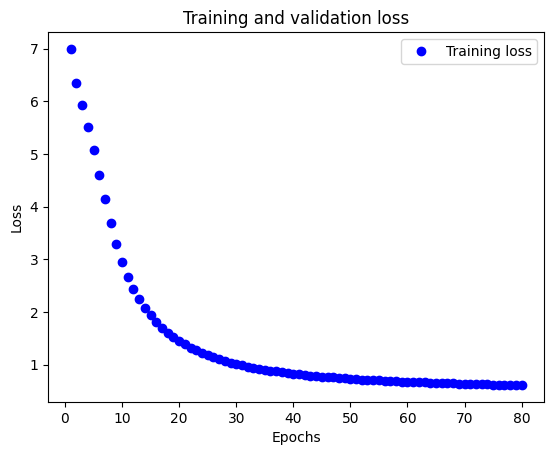

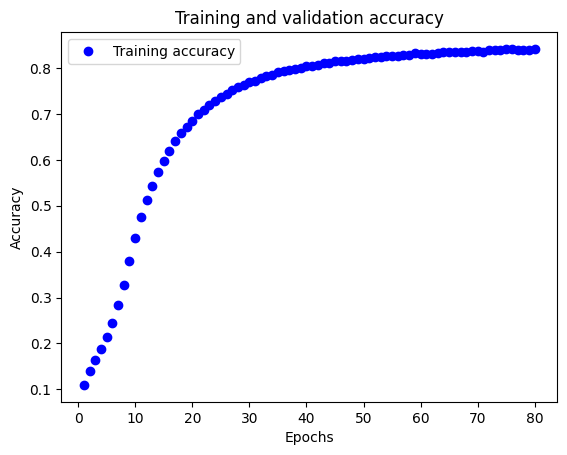

In [45]:
loss = history.history["loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history.history["accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [46]:
# Attaching the text vectorization layer to the model to create a model ready for inference
inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)
outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

# Save model
keras.models.save_model(inference_model, filepath='transformers_prediction.keras')

In [48]:
with open("label_dict.json", "r") as json_file:
   inverse_label_dict = json.load(json_file)

#print(inverse_label_dict)
seed_texts = [
    #'lost in the woods I heard the sounds of',
    #'bedtime loud noises were coming from the',
    #'sunset on the west',
    #'rain pours in the ceiling and there is sound of',
    'leaves fall gently onto the',
    'midnight whispers carry through the',
    'echoes of laughter fade into the',
    'shadows dance upon the',
    #'the air is thick with the scent of a',
    #'time slows when the waves',
    'clouds drift lazily across another',
    'A single candle flickers in',
    'Soft footsteps vanish into',
    'Memories linger where the wind',
    'Morning dew clings to the',
    'The stars fade as dawn',
    'Hearts beat in unison under',
    'Autumn moonlight— a worm digs silently',
    'Winter seclusion— listening, that evening,',
    'A world of dew, and within every dewdrop,',
    'In the cicada’s cry, no sign can foretell',
    'Over the still pond, the dragonfly hovers',
    'Cherry blossoms drift, carried by the gentle',
    'Snow falls in silence, covering the broken',
    'Spring air fills my lungs, a sparrow sings softly',
    'The river darkens, as twilight embraces it',
    'Falling leaves scatter, whispering their last goodbye',
    'On a withered branch, a crow has settled',
    'The summer grasses— all that remains of warriors’ dreams',
    'First winter rain— even the monkey wants',
    'Clouds of butterflies— the temple bell fades into',
    'Stillness and dusk— cicada voices soak into',
    'The sea darkens— a wild duck’s call is',
    'Chrysanthemums bloom— in the old wooden temple',
    'this hambuguer tastes like'
]

# seed_texts = [
#     'Clouds drift lazily across',
#     'Hearts beat in unison under',
#     'Soft footsteps vanish into',
# ]

model = keras.models.load_model(
    "transformers_prediction.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})

def top_n_indices(arr, n):
    if len(arr) < n:
        raise ValueError(f"Array must have at least {n} elements")

    return sorted(range(len(arr)), key=lambda i: arr[i], reverse=True)[:n]

n = 10
for seed_text in seed_texts:
    print(seed_text)
    seed_len = len(seed_text)
    seed_tensor = tf.convert_to_tensor([[seed_text]])
    next_words_probs = model.predict(seed_tensor, verbose=0)[0].tolist()
    top_probs_indexes = top_n_indices(next_words_probs, n)
    for index in top_probs_indexes:
        next_word = inverse_label_dict[str(index)]
        #print(f'{seed_text} {next_word}')
        print(' '*seed_len, next_word)


leaves fall gently onto the
                            book
                            snow
                            cherry
                            red
                            river
                            growth
                            equinox
                            cemetery
                            of
                            green
midnight whispers carry through the
                                    long
                                    twilight
                                    bend
                                    mountain
                                    morning
                                    river's
                                    crack
                                    tall
                                    floats
                                    eye
echoes of laughter fade into the
                                 stolen
                                 stillness
                                 fireflies
           

In [ ]:
n = 1 # "Creativity"
seed_text = input("Enter a word: ")

while True:
    seed_tensor = tf.convert_to_tensor([[seed_text.lower()]])
    #print(seed_tensor)
    next_words_probs = model.predict(seed_tensor, verbose=0)[0].tolist()
    top_probs_indexes = top_n_indices(next_words_probs, n)

    next_index = random.choice(top_probs_indexes)
    next_word = inverse_label_dict[str(next_index)]
    seed_text += ' ' + next_word
    print(f' - {seed_text}')
    next_input = input("Enter next word (or 'exit' to stop): ")
    seed_text = seed_text + ' ' + next_input
    if next_input.lower() == 'exit' or '.' in next_input:
        break

Enter a word:  the deep dive of a 


 - the deep dive of a  car


Enter next word (or 'exit' to stop):  into the


 - the deep dive of a  car into the rabbit's


Enter next word (or 'exit' to stop):  


 - the deep dive of a  car into the rabbit's  ear


In [82]:
n = 5  # "Creativity"
seed_text = input("Enter a phrase: ")

while True:
    #seed_tensor = tf.convert_to_tensor([[seed_text.lower()]])
    seed_tensor = tf.convert_to_tensor([[seed_text.lower()]])
    #print(seed_tensor)
    next_words_probs = model.predict(seed_tensor, verbose=0)[0].tolist()
    top_probs_indexes = top_n_indices(next_words_probs, n)
    #print('Options:', [inverse_label_dict[str(next_index)] for next_index in top_probs_indexes])
    #next_index = random.choice(top_probs_indexes)
    for next_index in top_probs_indexes:
        next_word = inverse_label_dict[str(next_index)]
        #seed_text += ' ' + next_word
        print(f' - {seed_text} {next_word}')
    #next_input = input("Enter next word (or 'exit' to stop): ")
    next_input = input("")
    #seed_text = seed_text + ' ' + next_input
    seed_text = next_input
    if next_input.lower() == 'exit' or '.' in next_input:
        break

Enter a word:  Tuples were full of


 - Tuples were full of sparrows
 - Tuples were full of fog
 - Tuples were full of a
 - Tuples were full of traffic
 - Tuples were full of the


KeyboardInterrupt: Interrupted by user